In [1]:
from qat.lang.AQASM import Program, H, CNOT, RZ,  AbstractGate
import numpy as np
from helpers import ansatz

In [2]:
nBits = 8

import json
import matplotlib.pylab as plt

with open('hamiltonian_data.json','r') as f:
    hams = json.load(f)

In [3]:
coeffs = hams[0]

In [4]:
import numpy as np

I = np.eye(4)
#plt.matshow(I)

Z0 = np.diag([1,1,-1,-1])
#plt.matshow(Z0)

Z1 = np.diag([1,-1,1,-1])
#plt.matshow(Z1)

Z0Z1 = np.diag([1,-1,-1,1])
#plt.matshow(Z0Z1)

X0X1 = np.fliplr(np.eye(4))
#plt.matshow(X0X1)

Y0Y1 = np.fliplr(np.diag([-1, 1, 1, -1]))
#plt.matshow(Y0Y1)

In [5]:
shift = 2.

Ham = coeffs['I_coeff'] * I
Ham += coeffs['Z0_coeff'] * Z0
Ham += coeffs['Z1_coeff'] * Z1
Ham += coeffs['Z0Z1_coeff'] * Z0Z1
Ham += coeffs['X0X1_coeff'] * X0X1
Ham += coeffs['Y0Y1_coeff'] * Y0Y1
Ham += shift * I
w, v = np.linalg.eigh(Ham)

In [6]:
def eigen_vecs(coeffs, shift):
    Ham = coeffs['I_coeff'] * I
    Ham += coeffs['Z0_coeff'] * Z0
    Ham += coeffs['Z1_coeff'] * Z1
    Ham += coeffs['Z0Z1_coeff'] * Z0Z1
    Ham += coeffs['X0X1_coeff'] * X0X1
    Ham += coeffs['Y0Y1_coeff'] * Y0Y1
    Ham += shift * I
    w, v = np.linalg.eigh(Ham)
    return v

eigen_prep = AbstractGate("eigen", 
                          [dict, float], 
                          arity = 2, 
                          matrix_generator=eigen_vecs)

In [7]:
prog = Program()
prog_ansatz = Program()

q = prog.qalloc(3)
q2 = prog_ansatz.qalloc(3)

prog.apply(eigen_prep(coeffs, shift), q[1], q[2])
prog_ansatz.apply(ansatz(0.), q[1], q[2])

circ = prog.to_circ()
circ_ansatz = prog_ansatz.to_circ()

from qat.qpus import get_default_qpu
qpu = get_default_qpu()

In [8]:
job = circ.to_job(qubits = [0,1,2])
job_ansatz = circ_ansatz.to_job()

result = qpu.submit(job)
result_ansatz = qpu.submit(job_ansatz)

print("Ground state:")
for sample in result:
    print(sample.probability,sample.amplitude,sample.state)
    
print("Ansatz:")
for sample in result_ansatz:
    print(sample.probability,sample.amplitude,sample.state)

Ground state:
0.0015284718671176797 (0.03909567581098554+0j) |001>
0.9984715281328823 (-0.9992354718147681+0j) |010>
Ansatz:
1.0 (1+0j) |010>


In [9]:
print(v[:,0])


[ 0.          0.03909568 -0.99923547  0.        ]


In [10]:
print(v,w)

[[ 0.          1.         -0.          0.        ]
 [ 0.03909568  0.         -0.99923547  0.        ]
 [-0.99923547  0.         -0.03909568  0.        ]
 [ 0.          0.         -0.          1.        ]] [2.14421033 4.6458     6.19378967 6.4118    ]


In [11]:
from scipy import linalg

E_max = 3
E_min = 0.5
    
dt = (2 * np.pi) / float(E_max)
    

def unit_ev(coeffs, shift, k):
    Ham = coeffs['I_coeff'] * I
    Ham += coeffs['Z0_coeff'] * Z0
    Ham += coeffs['Z1_coeff'] * Z1
    Ham += coeffs['Z0Z1_coeff'] * Z0Z1
    Ham += coeffs['X0X1_coeff'] * X0X1
    Ham += coeffs['Y0Y1_coeff'] * Y0Y1
    Ham += shift * I

    return linalg.expm(-1j * Ham * (2**k) * dt)

u_k = AbstractGate("uk", 
                   [dict, float, int], 
                   arity=2, 
                   matrix_generator=unit_ev)

In [12]:
bits = {}

for k in range(nBits, 0, -1):
    prog = Program()
    
    q = prog.qalloc(3)
    
    prog.apply(H, q[0])    
    prog.apply(eigen_prep(coeffs, shift), q[1], q[2])

    prog.apply(u_k(coeffs, shift, k-1).ctrl(), q)
    
    phi_k = 0

    for l in range(k+1, nBits+1, 1):
        phi_k += bits[l] / float(2**(l-k+1))
    
    phi_k *= 2 * np.pi
    
    prog.apply(RZ(phi_k), q[0])
    prog.apply(H, q[0])
    
    job = prog.to_circ().to_job(qubits=[0])
    
    result = qpu.submit(job)
    
    max_proba = -1
    max_state = -1
    for sample in result:
        print(sample.probability, sample.state)
        if sample.probability > max_proba:
            max_proba = sample.probability
            max_state = sample._state
     
    bits[k] = max_state
    
print(bits)
print([bits[k] for k in range(1,nBits+1,1)])

0.0018492587434176325 |0>
0.998150741256493 |1>
0.0004625286185774287 |0>
0.9995374713813778 |1>
0.00011564552853262693 |0>
0.9998843544714447 |1>
0.9999710877819391 |0>
2.8912218049509923e-05 |1>
7.22810675790479e-06 |0>
0.9999927718932363 |1>
1.8070299548334159e-06 |0>
0.9999981929700423 |1>
0.9999995482423056 |0>
4.5175769279344695e-07 |1>
1.1293943595363144e-07 |0>
0.999999887060563 |1>
{8: 1, 7: 1, 6: 1, 5: 0, 4: 1, 3: 1, 2: 0, 1: 1}
[1, 0, 1, 1, 0, 1, 1, 1]


In [13]:
phi = 0
for l in range(1,nBits+1):
    print(l)
    phi += float(bits[l])/float(2**l)
    
print(phi)

1
2
3
4
5
6
7
8
0.71484375


In [14]:
def phase(coeffs, ansatz_prep=False, ansatz_angle=0.01):
    Ham = coeffs['I_coeff'] * I
    Ham += coeffs['Z0_coeff'] * Z0
    Ham += coeffs['Z1_coeff'] * Z1
    Ham += coeffs['Z0Z1_coeff'] * Z0Z1
    Ham += coeffs['X0X1_coeff'] * X0X1
    Ham += coeffs['Y0Y1_coeff'] * Y0Y1
    Ham += shift * I
    w, v = np.linalg.eigh(Ham)
    
    bits = {}

    for k in range(nBits, 0, -1):
        prog = Program()

        q = prog.qalloc(3)

        prog.apply(H, q[0])
        if ansatz_prep:
            prog.apply(ansatz(ansatz_angle), q[1], q[2])
        else:
            prog.apply(eigen_prep(coeffs, shift), q[1], q[2])

        prog.apply(u_k(coeffs, shift, k-1).ctrl(), q)

        phi_k = 0

        for l in range(k+1, nBits+1, 1):
            phi_k += bits[l] / float(2**(l-k+1))

        phi_k *= 2 * np.pi

        prog.apply(RZ(phi_k), q[0])
        prog.apply(H, q[0])

        job = prog.to_circ().to_job(qubits=[0])

        result = qpu.submit(job)

        max_proba = -1
        max_state = -1
        for sample in result:
            if sample.probability > max_proba:
                max_proba = sample.probability
                max_state = sample._state
     
        bits[k] = max_state
    
    print([bits[k] for k in range(1,nBits+1,1)])
        
    phi = 0
    for l in range(1,nBits+1,1):
        phi += float(bits[l])/float(2**l)
            
    return phi


In [15]:
vals = []
vals_ansatz = []
Rs = []
for coeffs in hams:
    phi_c = phase(coeffs)
    phi_ansatz = phase(coeffs, ansatz_prep=True, ansatz_angle=0.1)
    
    E = ((2*np.pi)/dt)*phi_c
    E_ansatz = ((2*np.pi)/dt)*phi_ansatz

    Rs.append(coeffs['R'])
    
    vals.append(E-shift)
    vals_ansatz.append(E_ansatz-shift)
    


[1, 0, 1, 1, 0, 1, 1, 1]
[1, 0, 1, 1, 0, 1, 1, 1]
[1, 0, 0, 0, 1, 1, 1, 1]
[1, 0, 0, 0, 1, 1, 1, 1]
[0, 1, 1, 1, 0, 1, 1, 0]
[0, 1, 1, 1, 0, 1, 1, 0]
[0, 1, 1, 0, 0, 1, 1, 0]
[0, 1, 1, 0, 0, 1, 1, 0]
[0, 1, 0, 1, 1, 1, 0, 0]
[0, 1, 0, 1, 1, 1, 0, 0]
[0, 1, 0, 1, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 0]
[0, 1, 0, 1, 0, 0, 0, 0]
[0, 1, 0, 0, 1, 1, 0, 1]
[0, 1, 0, 0, 1, 1, 0, 1]
[0, 1, 0, 0, 1, 0, 1, 1]
[0, 1, 0, 0, 1, 0, 1, 1]
[0, 1, 0, 0, 1, 0, 0, 1]
[0, 1, 0, 0, 1, 0, 0, 1]
[0, 1, 0, 0, 1, 0, 0, 1]
[0, 1, 0, 0, 1, 0, 0, 1]
[0, 1, 0, 0, 1, 0, 0, 1]
[0, 1, 0, 0, 1, 0, 0, 1]
[0, 1, 0, 0, 1, 0, 0, 1]
[0, 1, 0, 0, 1, 0, 0, 1]
[0, 1, 0, 0, 1, 0, 1, 0]
[0, 1, 0, 0, 1, 0, 1, 0]
[0, 1, 0, 0, 1, 0, 1, 0]
[0, 1, 0, 0, 1, 0, 1, 0]
[0, 1, 0, 0, 1, 0, 1, 1]
[0, 1, 0, 0, 1, 0, 1, 1]
[0, 1, 0, 0, 1, 1, 0, 0]
[0, 1, 0, 0, 1, 1, 0, 0]
[0, 1, 0, 0, 1, 1, 0, 1]
[0, 1, 0, 0, 1, 1, 0, 1]
[0, 1, 0, 0, 1, 1, 1, 0]
[0, 1, 0, 0, 1, 1, 1, 0]
[0, 1, 0, 0, 1, 1, 1, 1]
[0, 1, 0, 0, 1, 1, 1, 1]


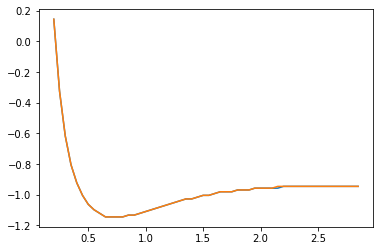

In [16]:
plt.plot(Rs,vals)
plt.plot(Rs,vals_ansatz)